In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data 


In [2]:
FundAUM=1e9

In [3]:
mkts=get_market_list()
curr_px=get_most_liquid_price(mkts)
df=pd.DataFrame()
for m in mkts:
    df[m]=get_timeseries(m)

# Idea is to add two different look back signals to the same model

* In theory every level should be vol scaled to ensure equal risk allocation (signal, market, and fund level as we don't have sectors here)
* Need to get the scaling factor correct.  Problably best to get the scaling factor correct in signal space then 

In [4]:
pnl_combinations = pd.DataFrame()
for sh in range(10,60,10):
    for lg in range(20,100,10):
        if lg<=sh:
            continue
        pos=tsmom_daily(df[mkts],sh)
        pnl_short=calc_pnl_wc(pos,df[mkts])
        pos=tsmom_daily(df[mkts],lg)
        pnl_long=calc_pnl_wc(pos,df[mkts])
        combined_pnl=(pnl_short*.5+pnl_long*.5)
        scaling_factor=calc_scaling_factor(combined_pnl)
        s_short=tsmom_daily_signal(df,sh)
        s_long=tsmom_daily_signal(df,lg)
        s_combined = (s_short*.5+s_long*.5)
        lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)
        PNL = calc_pnl_position_wc(lots,df,curr_px,0.0003)
        pnl_combinations[str(sh)+','+str(lg)]=(PNL.sum(axis=1)/FundAUM).dropna()       

model.py:8: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
model.py:9: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:9: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:16: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(25

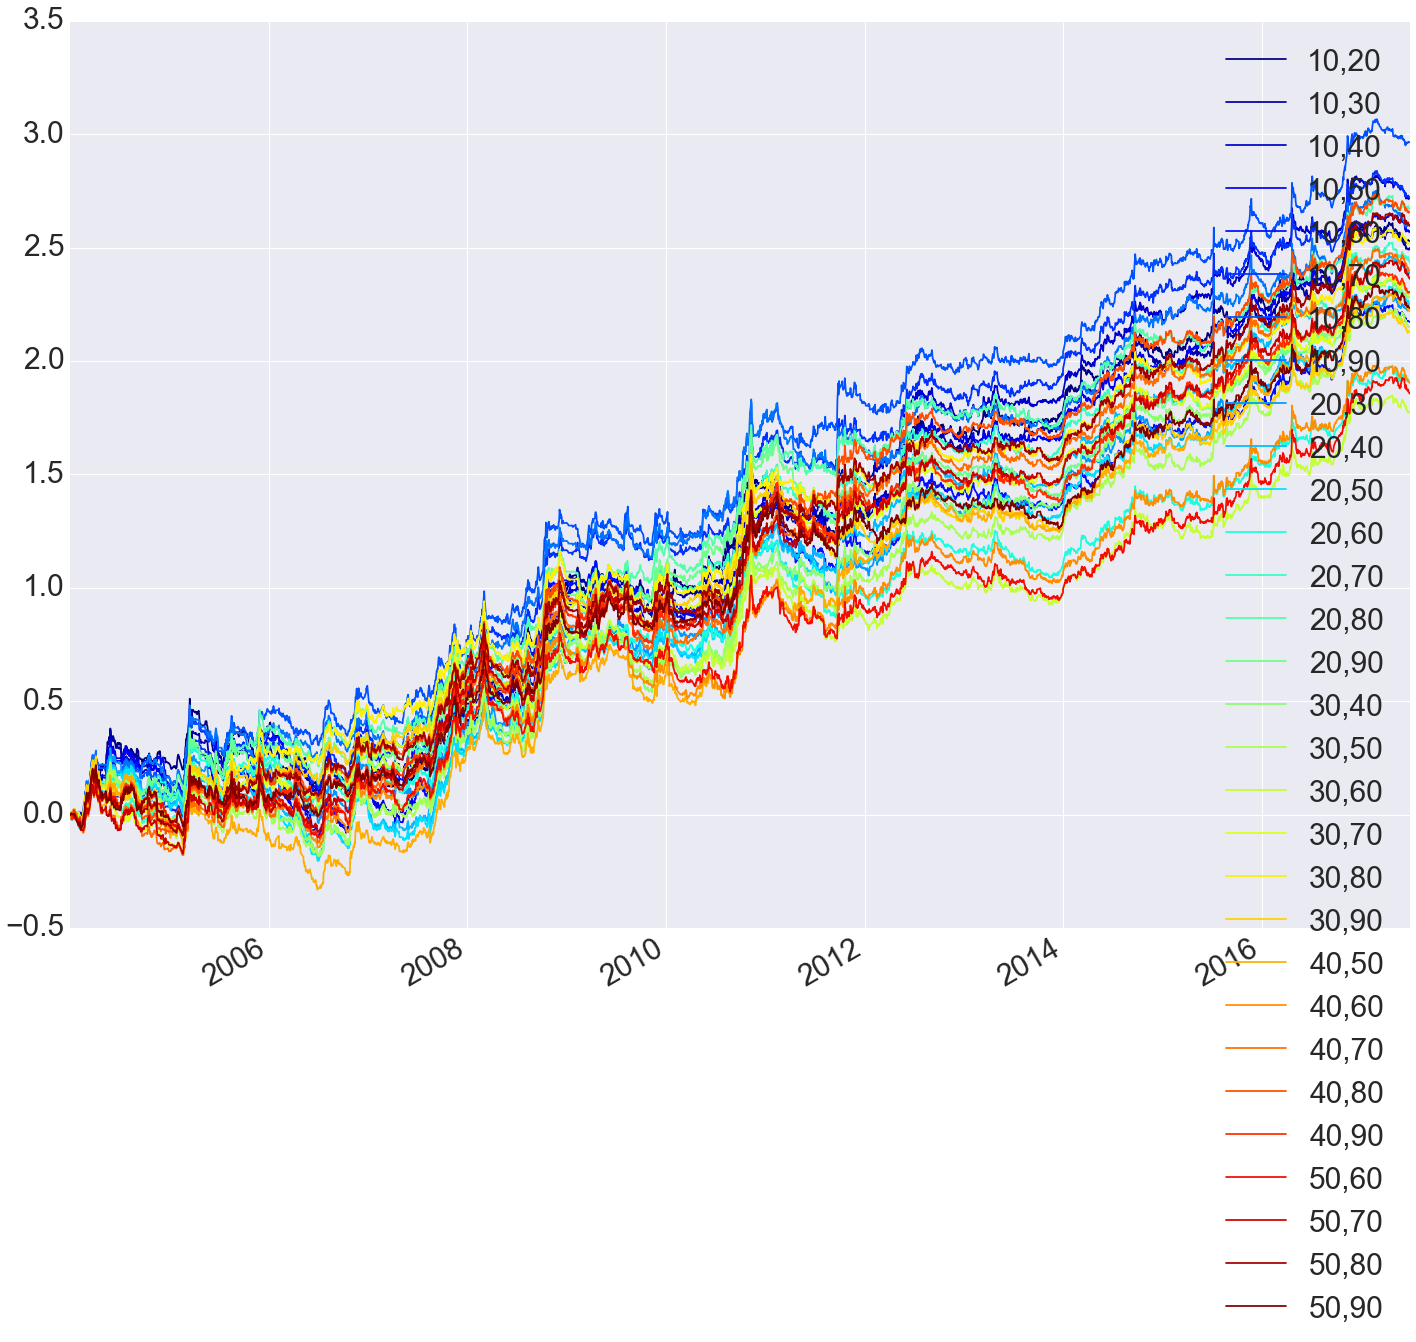

In [5]:
pnl_combinations=remove_inf(pnl_combinations)
pnl_combinations['2004':].cumsum().plot(colormap='jet')

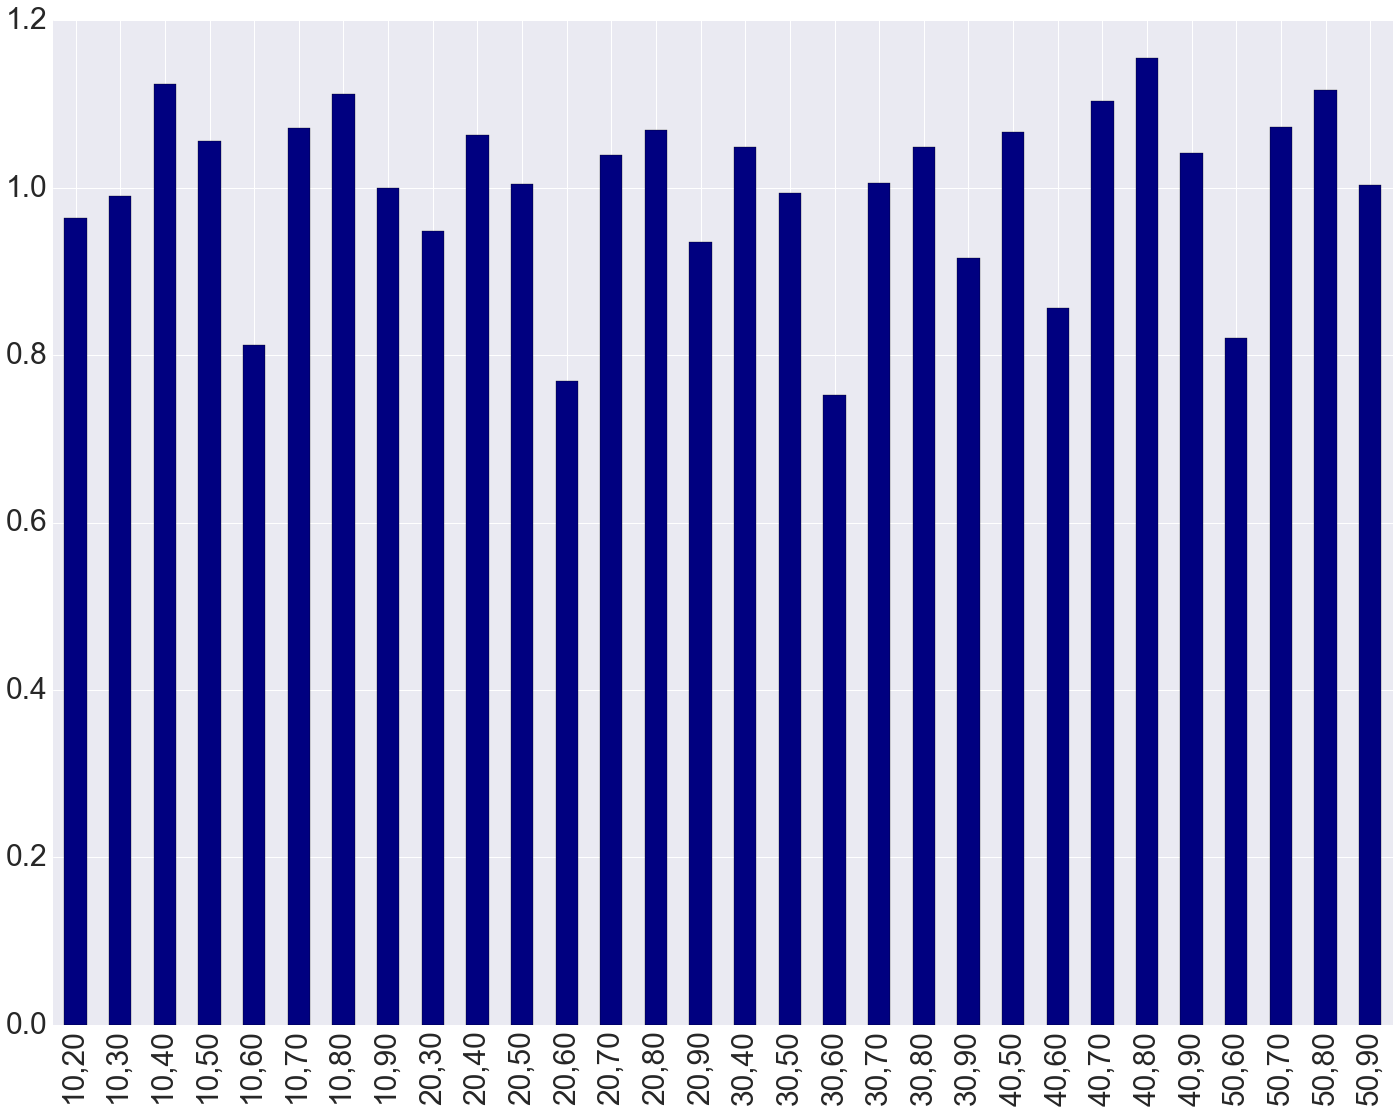

In [6]:
calc_Sharpe(pnl_combinations['2006':]).plot(kind='bar',colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=1000000,center=False).max()
  from IPython.kernel.zmq import kernelapp as app


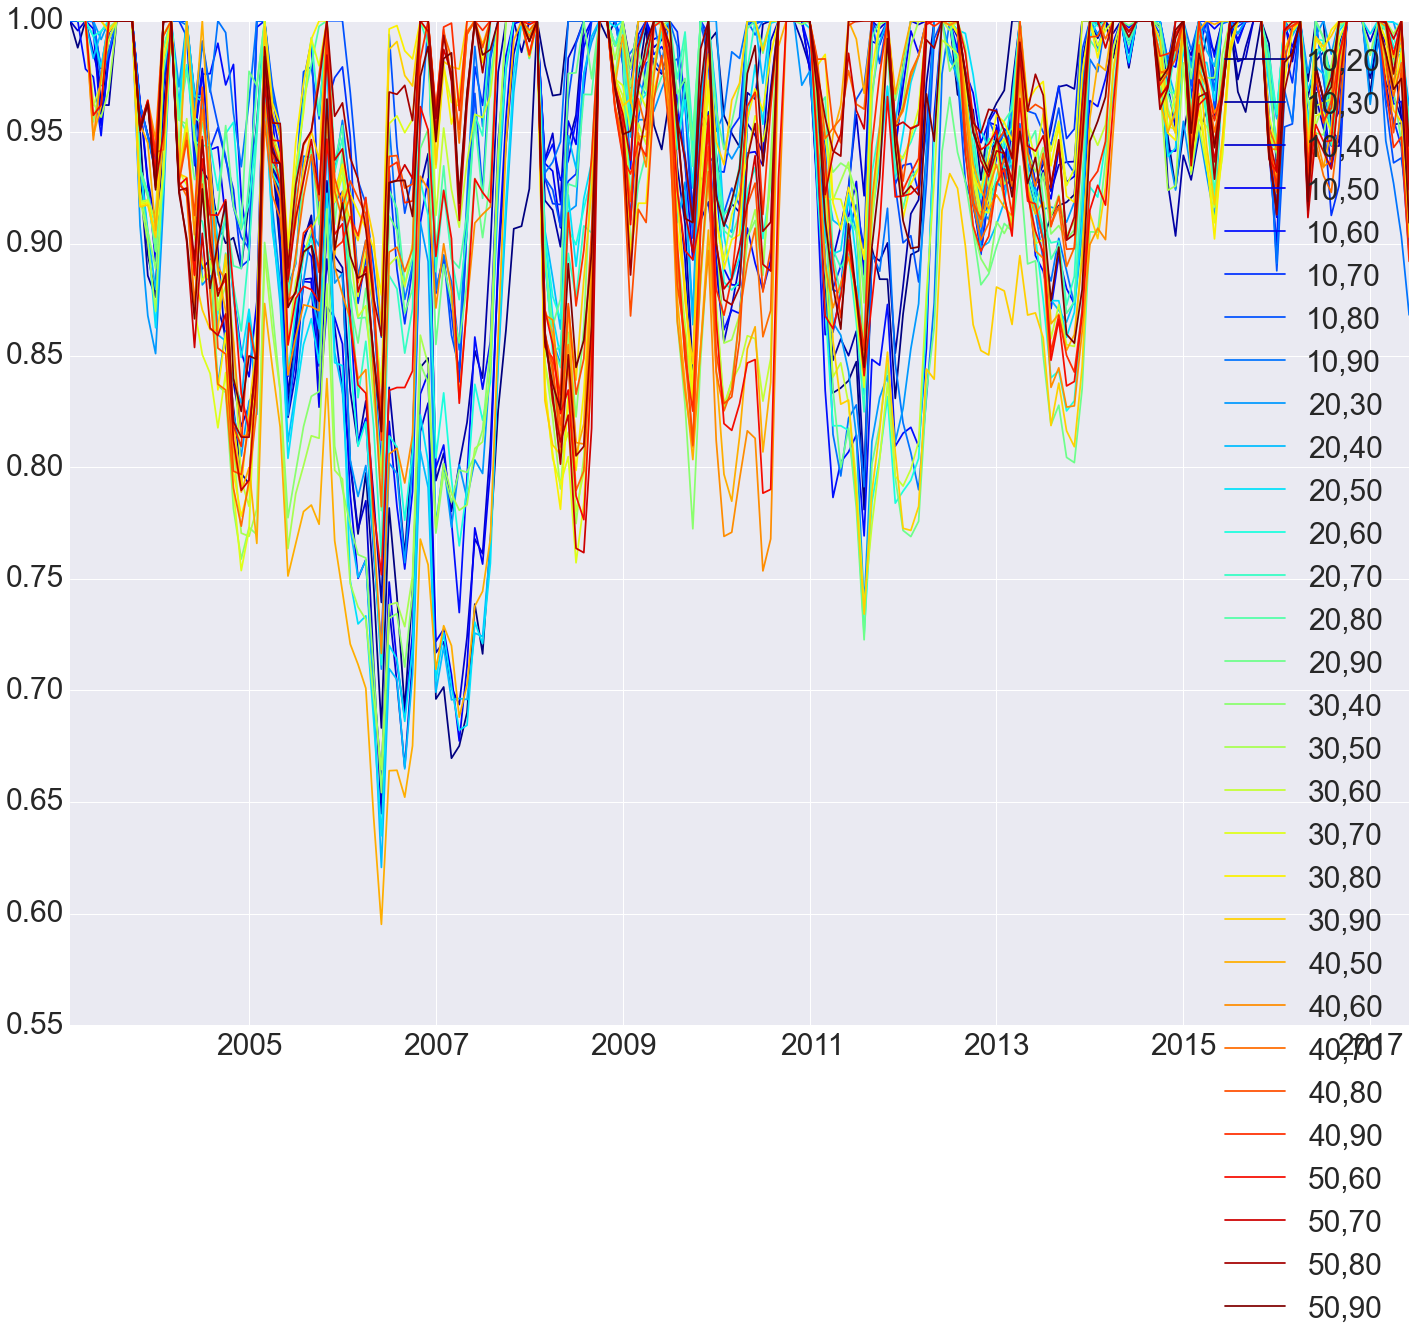

In [7]:
temp=(pnl_combinations.resample(rule='m',how='sum')+1).cumprod()
(temp/pd.rolling_max(temp,1000000,min_periods=1)).plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=1000000,center=False).max()
  if __name__ == '__main__':


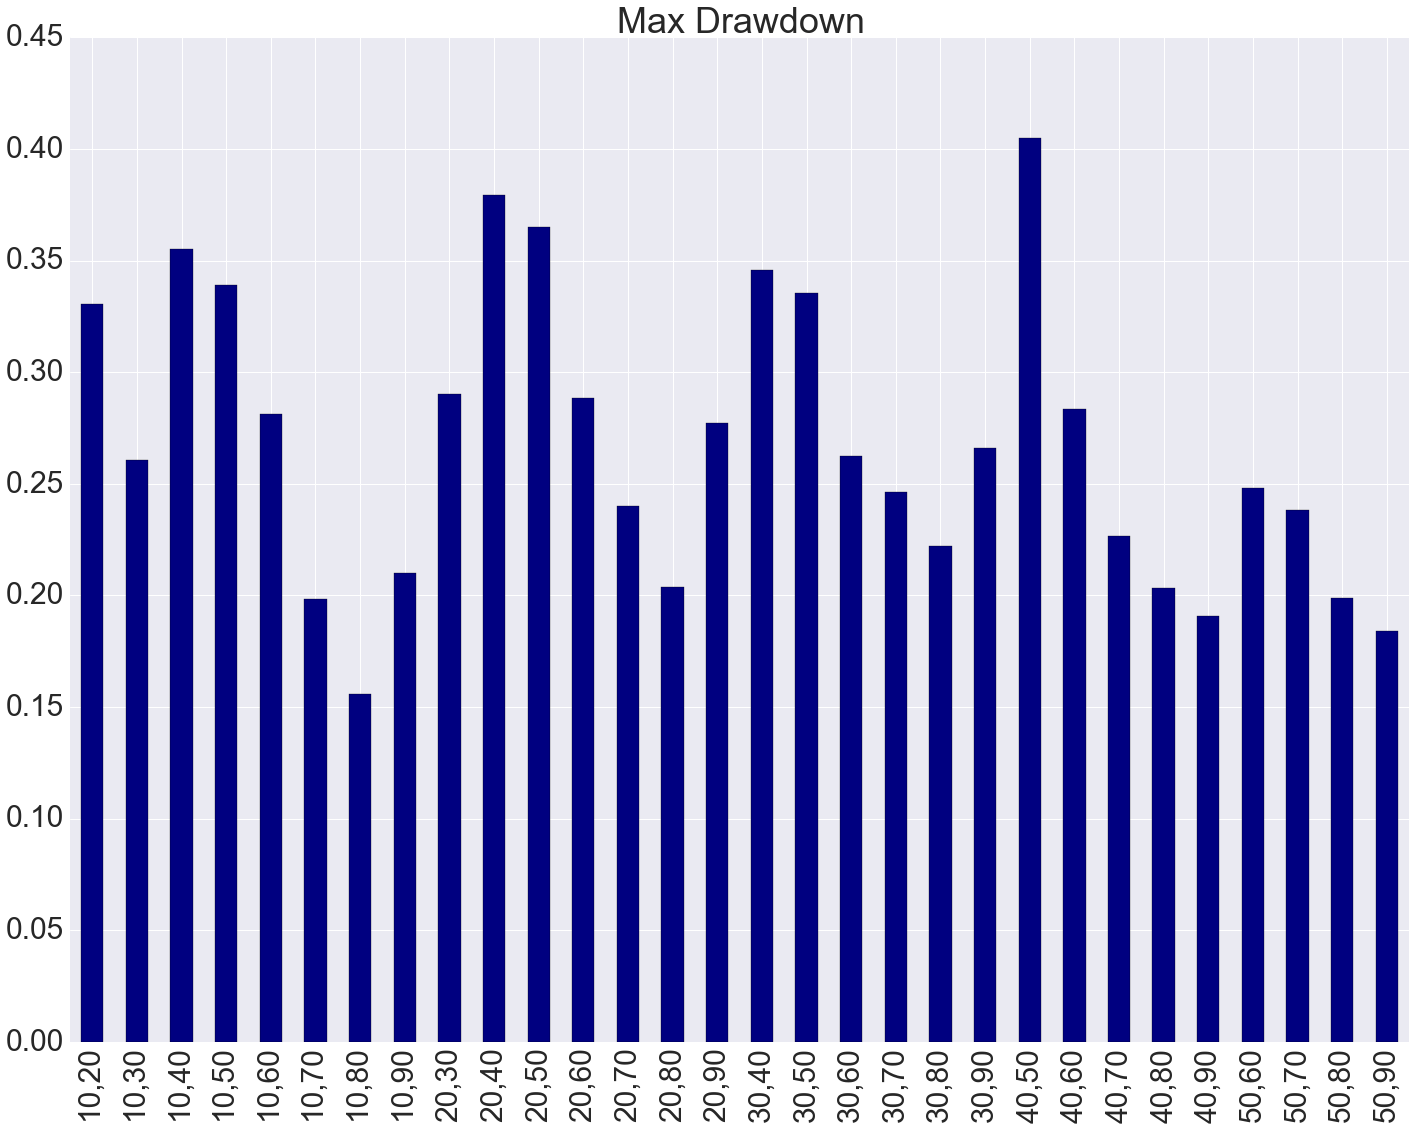

In [8]:
temp2=(1-(temp/pd.rolling_max(temp,1000000,min_periods=1)).min())
temp2.plot(kind='bar',colormap='jet',title='Max Drawdown')

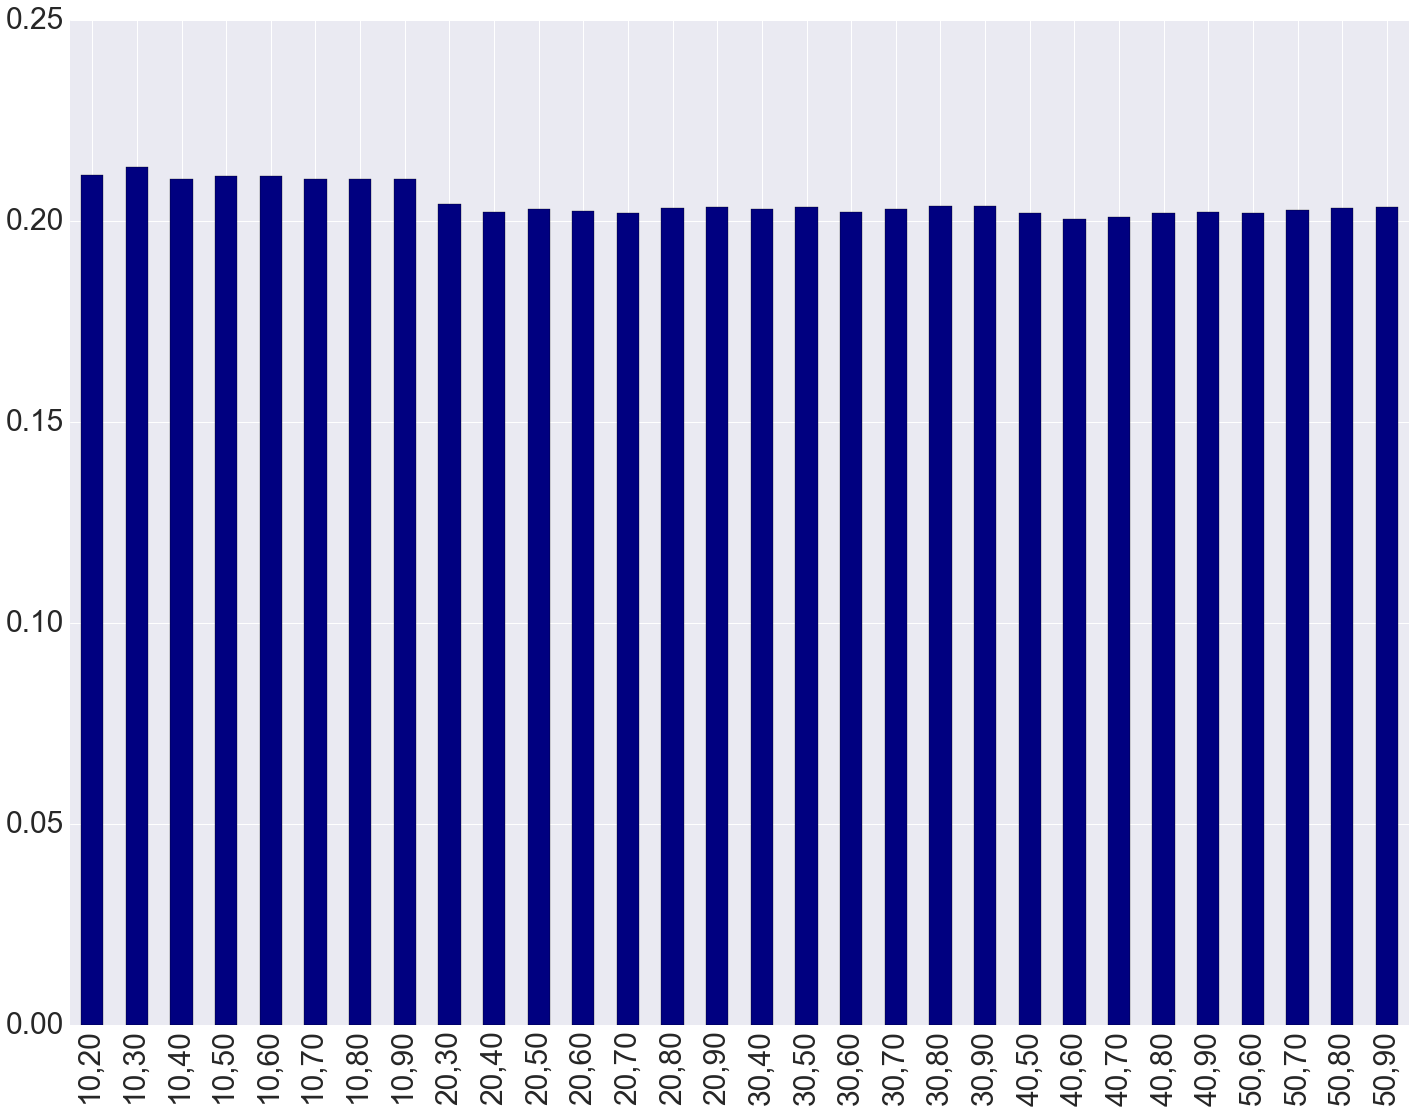

In [9]:
(pnl_combinations.std()*16).plot(kind='bar',colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


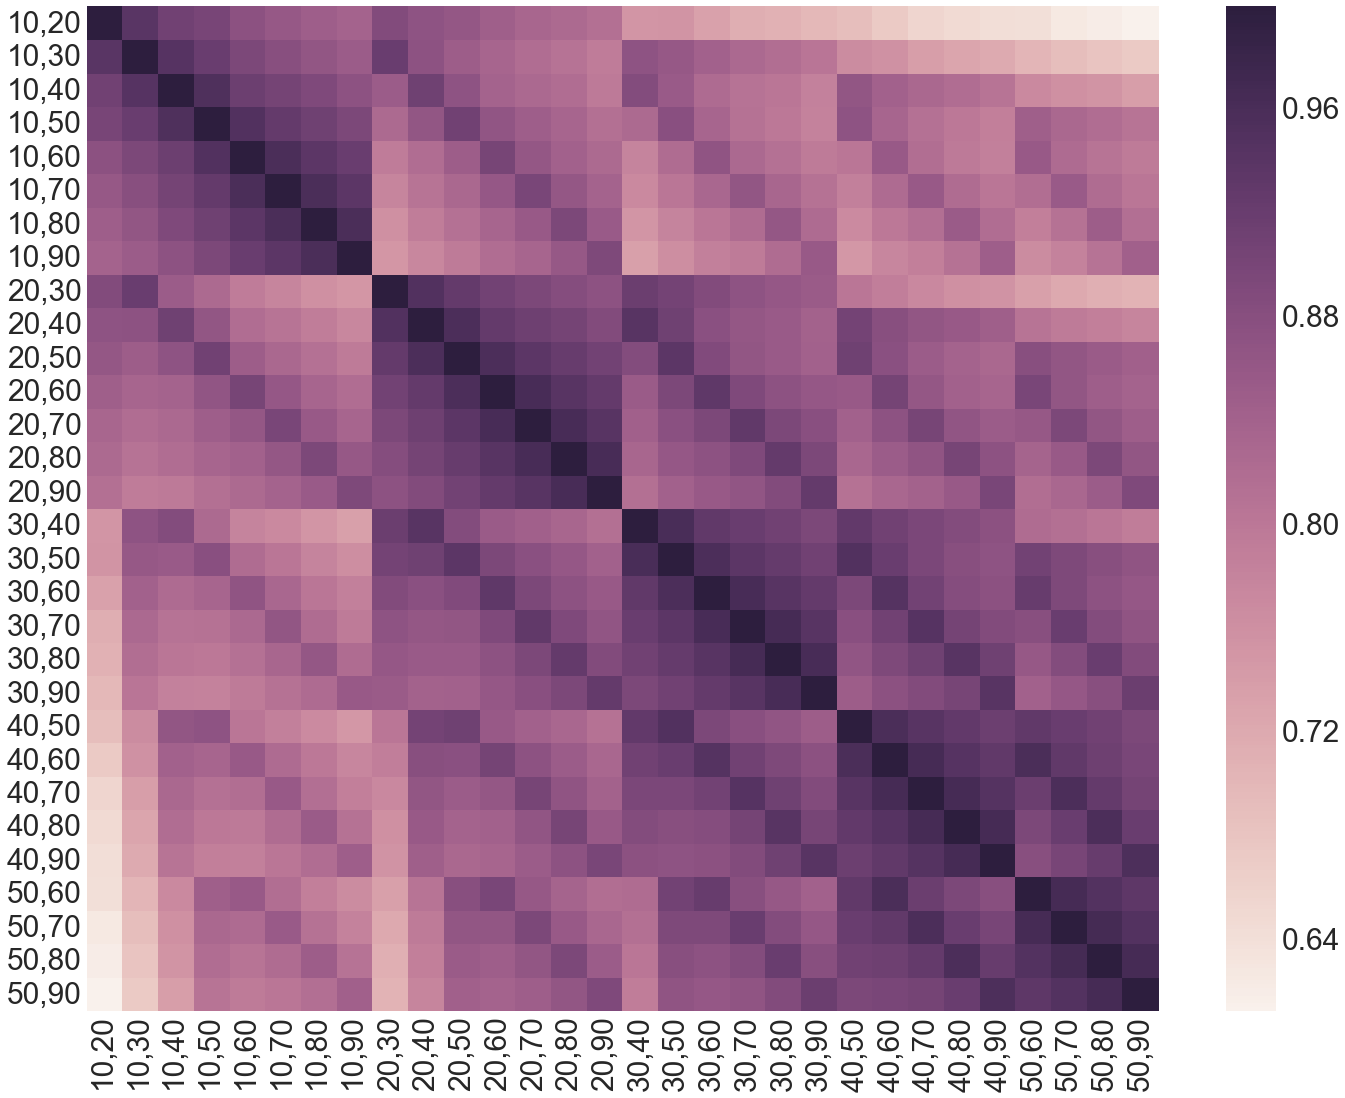

In [10]:
sns.heatmap(pnl_combinations.corr())

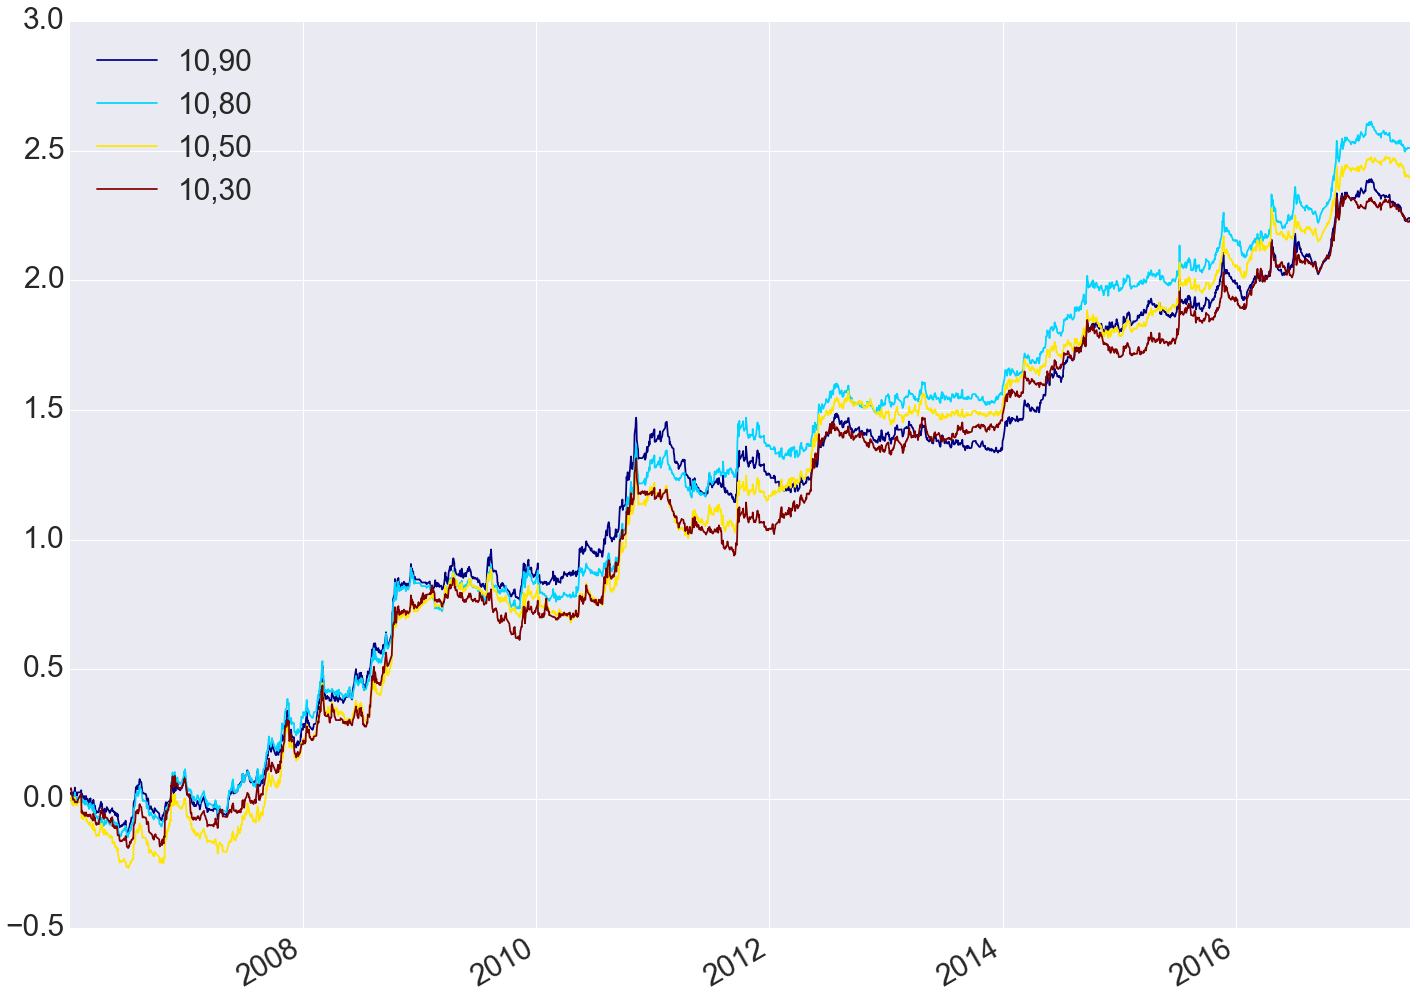

In [11]:
pnl_combinations['2006':][['10,90','10,80','10,50','10,30']].cumsum().plot(colormap='jet')

In [12]:
pos=tsmom_daily(df[mkts],10)
pnl_short=calc_pnl_wc(pos,df[mkts])
pos=tsmom_daily(df[mkts],80)
pnl_long=calc_pnl_wc(pos,df[mkts])
combined_pnl=(pnl_short*.5+pnl_long*.5)
scaling_factor=calc_scaling_factor(combined_pnl)
s_short=tsmom_daily_signal(df,10)
s_long=tsmom_daily_signal(df,80)
s_combined = (s_short*.5+s_long*.5)
lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)

In [13]:
mul=get_contract_multipliers()[df.columns]
cost=cost_model_position(lots,curr_px,mul,fee=0.0003)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


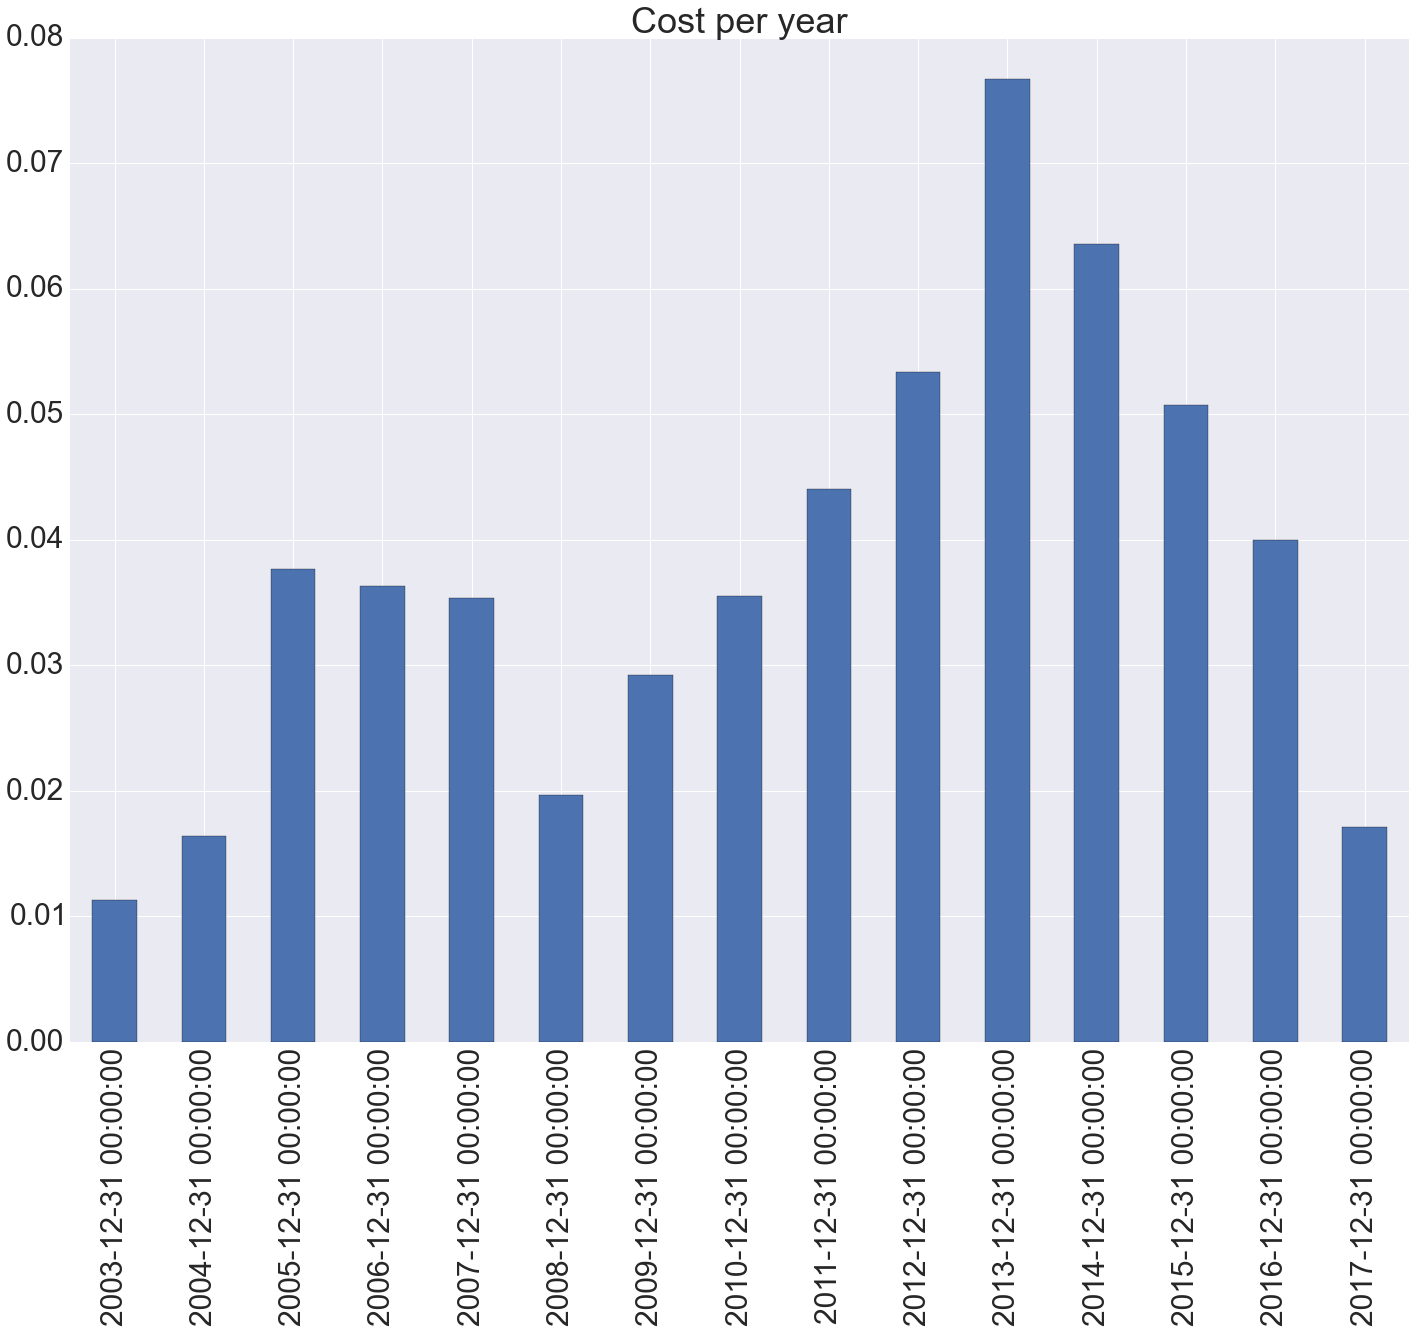

In [14]:
(cost.sum(axis=1).resample(rule='a',how='sum')/FundAUM).plot(kind='bar',title='Cost per year')